In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/kaggle/input/perrin-freres-monthly-champagne-sales/Perrin Freres monthly champagne sales millions.csv', index_col = 'Month', parse_dates = True)
df.index.freq = 'MS'  # Set the frequency as monthly start
df

,Perrin Freres monthly champagne sales millions ?64-?72
Month,
1964-01,2815.0
1964-02,2672.0
1964-03,2755.0
1964-04,2721.0
1964-05,2946.0
...,...
1972-07,4298.0
1972-08,1413.0
1972-09,5877.0


In [3]:
df.dropna(inplace = True)
df

,Perrin Freres monthly champagne sales millions ?64-?72
Month,
1964-01,2815.0
1964-02,2672.0
1964-03,2755.0
1964-04,2721.0
1964-05,2946.0
...,...
1972-05,4618.0
1972-06,5312.0
1972-07,4298.0


In [4]:
# Rename the column
df.rename(columns={'Perrin Freres monthly champagne sales millions ?64-?72': 'sales'}, inplace=True)
df.head()

,sales
Month,
1964-01,2815.0
1964-02,2672.0
1964-03,2755.0
1964-04,2721.0
1964-05,2946.0


In [5]:
df.index.dtype

dtype('O')

In [6]:
# Convert the index to datetime data type
from datetime import datetime
df.index = pd.to_datetime(df.index)
df.index.dtype

dtype('<M8[ns]')

In [7]:
df

,sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
...,...
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0


<Axes: xlabel='Month'>

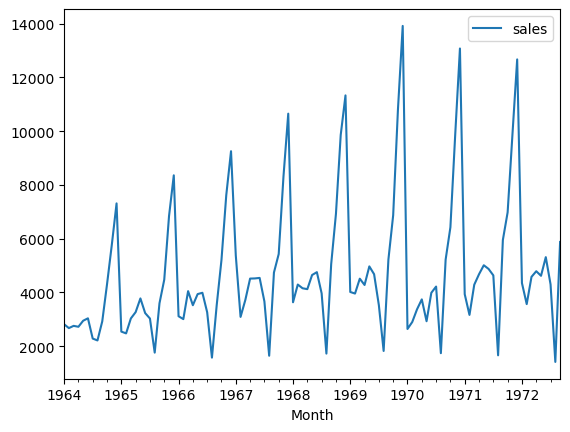

In [8]:
df.plot()

Text(0.5, 1.0, 'Lag plot of sales')

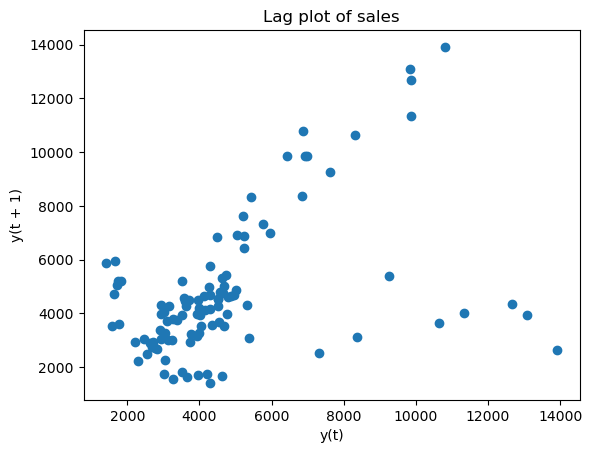

In [9]:
from pandas.plotting import lag_plot
lag_plot(df.sales)
plt.title('Lag plot of sales')

## ARIMA

In [10]:
df_arima = df.copy()

In [11]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [128]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [129]:
# Testing for stationarity
adfuller_test(df_arima['sales'])

ADF Test Statistic : -1.8335930563276215
p-value : 0.36391577166024586
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


#### Differencing to make data stationary

In [130]:
df_arima['sales First Difference'] = df_arima['sales'] - df_arima['sales'].shift(1)
df_arima.head()

,sales,sales First Difference
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,-143.0
1964-03-01,2755.0,83.0
1964-04-01,2721.0,-34.0
1964-05-01,2946.0,225.0


In [131]:
# Testing For Stationarity for the differenced sales

adfuller_test(df_arima['sales First Difference'].dropna())

ADF Test Statistic : -7.189896448050999
p-value : 2.519620447387081e-10
#Lags Used : 11
Number of Observations Used : 92
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='Month'>

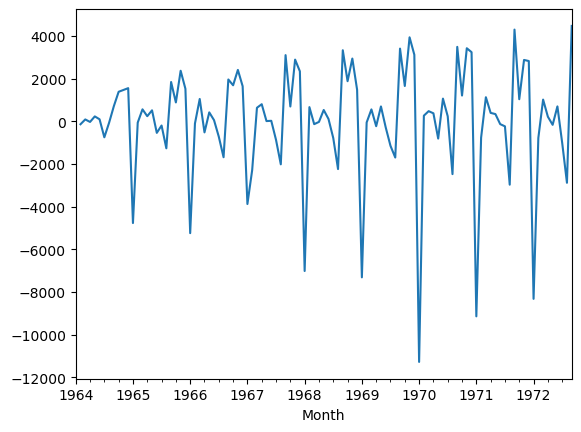

In [132]:
df_arima['sales First Difference'].plot()

Now, the p-value of first difference is less than 0.05, hence we say that the data is stationary.

Since we get stationary data in one difference, d = 1
Now we'll identify the p and d term from the PACF and ACF plots respectively

In [133]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

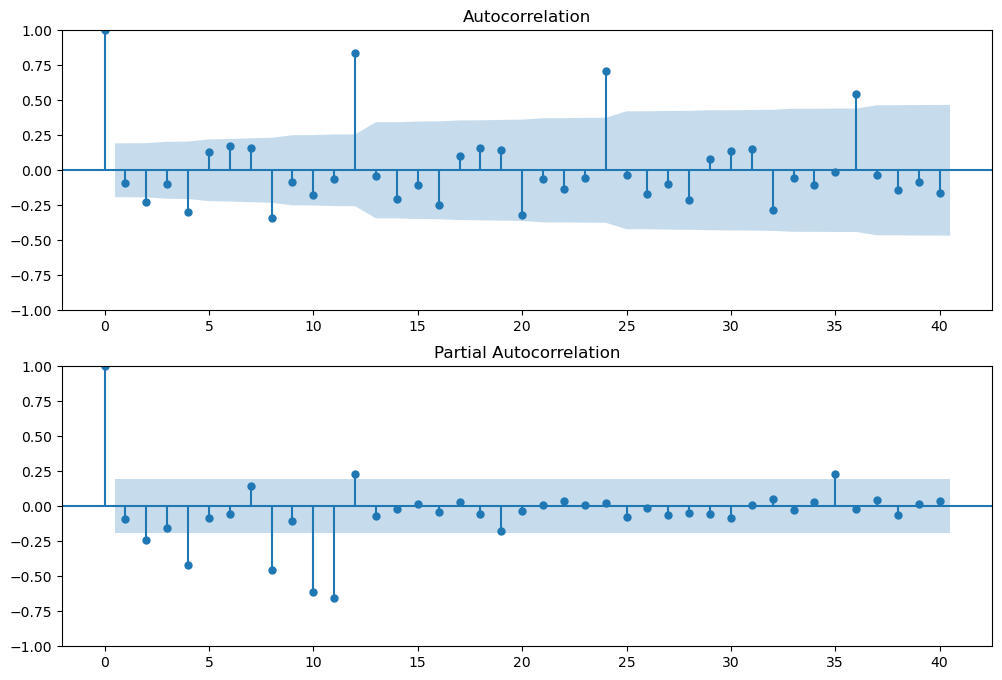

In [134]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_arima['sales First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_arima['sales First Difference'].dropna(),lags=40,ax=ax2)

### train - test split for First Differenced data

In [135]:
train = df_arima.iloc[1:len(df_arima)-12,1]
test= df_arima.iloc[len(df_arima)-12:,1]
train.shape, test.shape

((92,), (12,))

In [136]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(11, 1, 12))
model_fit_A = model.fit()
model_fit_A.summary()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:     sales First Difference   No. Observations:                   92
Model:                   ARIMA(11, 1, 12)   Log Likelihood                -749.643
Date:                    Tue, 22 Aug 2023   AIC                           1547.286
Time:                            05:31:05   BIC                           1607.547
Sample:                        02-01-1964   HQIC                          1571.598
                             - 09-01-1971                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9097      0.161     -5.642      0.000      -1.226      -0.594
ar.L2         -0.9214      0.104     -8.900      0.000      -1.124      -0.719
ar.L3         -0.9146      0.148     -6.197      0.000      -1.204      -0.625
ar.L4         -0.9969      0.110     -9.094      0.000      -1.212      -0.782
ar.L5         -0.9231      0.199     -4.629      0.000      -1.314      -0.532
ar.L6         -0.8954      0.125     -7.171      0.000      -1.140      -0.651
ar.L7         -0.8752      0.144     -6.098      0.000      -1.157      -0.594
ar.L8         -0.9719      0.089    -10.912      0.000      -1.147      -0.797
ar.L9         -0.8850      0.194     -4.561      0.000      -1.265      -0.505
ar.L10        -0.8712      0.092     -9.492      0.000      -1.051      -0.691
ar.L11        -0.8677      0.132     -6.581      0.000      -1.126      -0.609
ma.L1         -0.7902      0.225     -3.510      0.000      -1.231      -0.349
ma.L2         -0.0629      0.356     -0.177      0.860      -0.760       0.635
ma.L3          0.1456      0.328      0.444      0.657      -0.497       0.789
ma.L4         -0.0505      0.387     -0.131      0.896      -0.808       0.707
ma.L5         -0.3408      0.314     -1.086      0.278      -0.956       0.274
ma.L6         -0.0844      0.433     -0.195      0.845      -0.932       0.764
ma.L7          0.3824      0.361      1.058      0.290      -0.326       1.091
ma.L8          0.1279      0.289      0.443      0.658      -0.438       0.694
ma.L9         -0.3195      0.292     -1.094      0.274      -0.892       0.253
ma.L10        -0.0172      0.424     -0.040      0.968      -0.849       0.815
ma.L11         0.1724      0.410      0.421      0.674      -0.631       0.976
ma.L12        -0.0753      0.328     -0.229      0.819      -0.719       0.568
sigma2      6.157e+05   1.31e+05      4.696      0.000    3.59e+05    8.73e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                57.35
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.63   Skew:                            -1.11
Prob(H) (two-sided):                  0.19   Kurtosis:                         6.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [137]:
test.index

DatetimeIndex(['1971-10-01', '1971-11-01', '1971-12-01', '1972-01-01',
               '1972-02-01', '1972-03-01', '1972-04-01', '1972-05-01',
               '1972-06-01', '1972-07-01', '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

In [138]:
# Make predictions using the fitted model

start_date = '1971-10-01'
end_date = '1972-09-01'
forecast = model_fit_A.get_prediction(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date), dynamic=False)
forecast_values_test_arima = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

Text(0.5, 1.0, 'Predicted Test Differenced Vs Actual Test ifference')

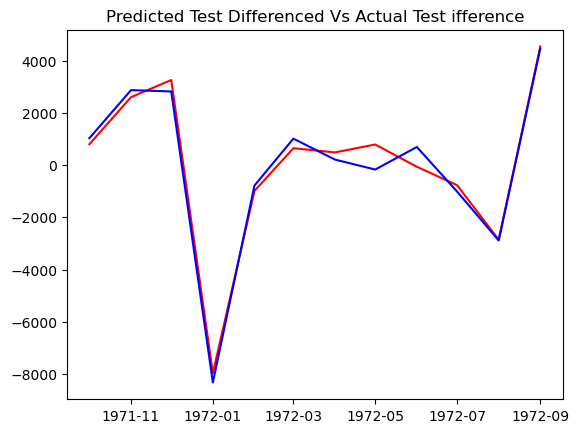

In [139]:
plt.plot(forecast_values_test_arima,'r')
plt.plot(test,'b')
plt.title('Predicted Test Differenced Vs Actual Test ifference')

In [140]:
# Undo the first differencing to get the original predictions on Train data:

predicted_values = np.zeros(len(forecast_values_test_arima) + 1)
predicted_values[0] = 5951.0    # last_value in original data for last date in train i.e. 1971-09-01

for i in range(1, len(predicted_values)):
    predicted_values[i] = predicted_values[i-1] + forecast_values_test_arima.values[i-1]

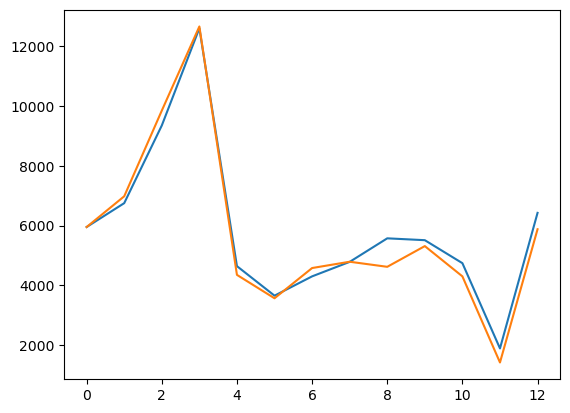

In [141]:
plt.plot(predicted_values)
plt.plot(df_arima.iloc[len(train):105,0].values)

In [142]:
# report performance
from sklearn.metrics import mean_squared_error
import math

mse = mean_squared_error(df_arima.iloc[len(train)+1:105,0].values, predicted_values[1:])
rmse = math.sqrt(mse)
print('RMSE: %.3f' % rmse)

RMSE: 422.635


In [143]:
df_arima

,sales,sales First Difference
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,-143.0
1964-03-01,2755.0,83.0
1964-04-01,2721.0,-34.0
1964-05-01,2946.0,225.0
...,...,...
1972-05-01,4618.0,-170.0
1972-06-01,5312.0,694.0
1972-07-01,4298.0,-1014.0


In [144]:
df

,sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
...,...
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0


# Holt-Winter model

## Train Test Split

In [145]:
train_data = df.iloc[:93] # Goes up to but not including 93
test_data = df.iloc[93:]

In [146]:
test_data

,sales
Month,
1971-10-01,6981.0
1971-11-01,9851.0
1971-12-01,12670.0
1972-01-01,4348.0
1972-02-01,3564.0
1972-03-01,4577.0
1972-04-01,4788.0
1972-05-01,4618.0
1972-06-01,5312.0


## Fitting the holtwinters model

In [147]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model = ExponentialSmoothing(train_data,trend='add',seasonal='add',seasonal_periods=12).fit()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## Predictions on test data

In [153]:
test_predictions = fitted_model.forecast(12).rename('HW Forecast')

In [154]:
test_predictions

1971-10-01     7046.262157
1971-11-01    10523.723481
1971-12-01    13535.445183
1972-01-01     4120.263998
1972-02-01     3658.624553
1972-03-01     4581.009010
1972-04-01     4905.842227
1972-05-01     4998.994853
1972-06-01     5112.929963
1972-07-01     4890.694610
1972-08-01     2159.609794
1972-09-01     6006.978706
Freq: MS, Name: HW Forecast, dtype: float64

<Axes: xlabel='Month'>

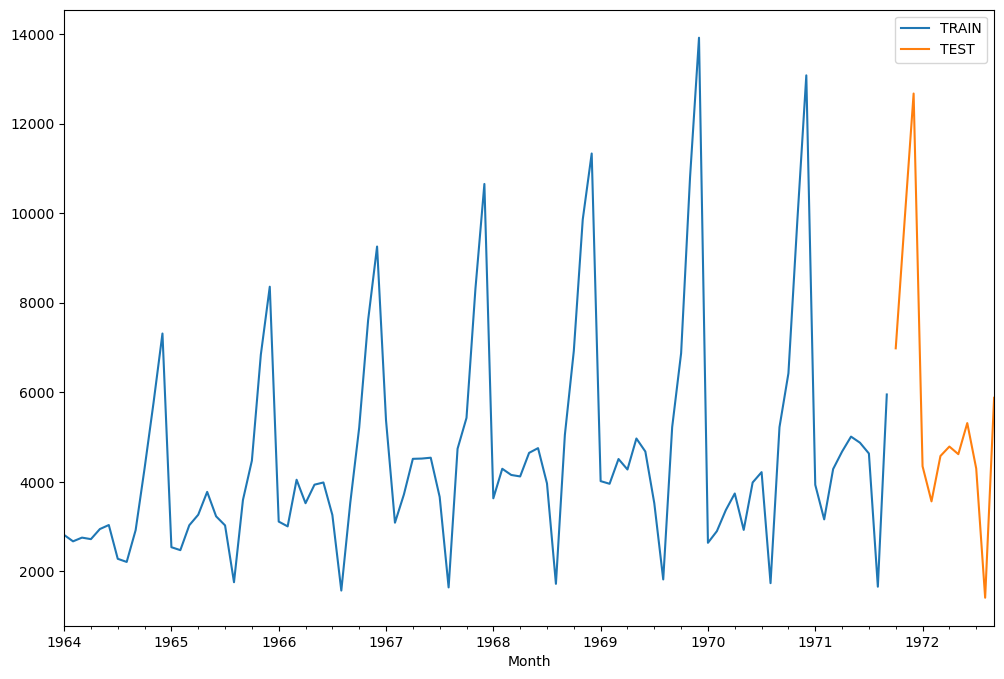

In [155]:
train_data['sales'].plot(legend=True,label='TRAIN')
test_data['sales'].plot(legend=True,label='TEST',figsize=(12,8))

<Axes: xlabel='Month'>

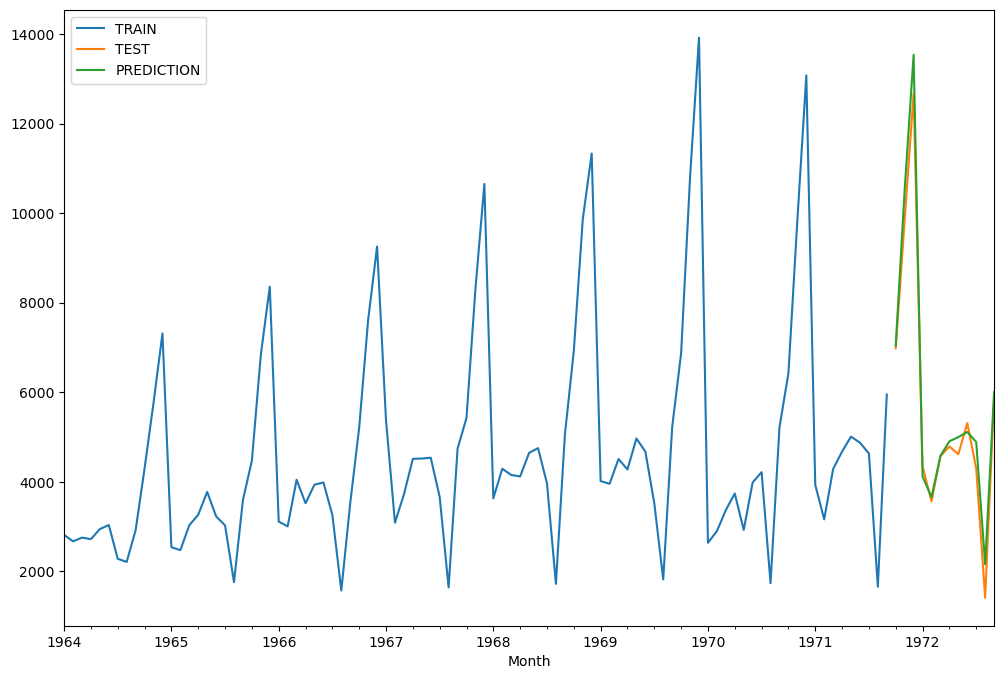

In [156]:
train_data['sales'].plot(legend=True,label='TRAIN')
test_data['sales'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION')

## Evaluation Metrics

In [157]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test_data,test_predictions))

446.3673056542062

In [158]:
test_data.describe()

,sales
count,12.000000
mean,5691.416667
std,2979.194841
min,1413.000000
25%,4335.500000
50%,4703.000000
75%,6153.000000
max,12670.000000


## Forecasting the future

In [159]:
final_model = ExponentialSmoothing(df['sales'],trend='add',seasonal='add',seasonal_periods=12).fit()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [160]:
forecast_predictions = final_model.forecast(20)

<Axes: xlabel='Month'>

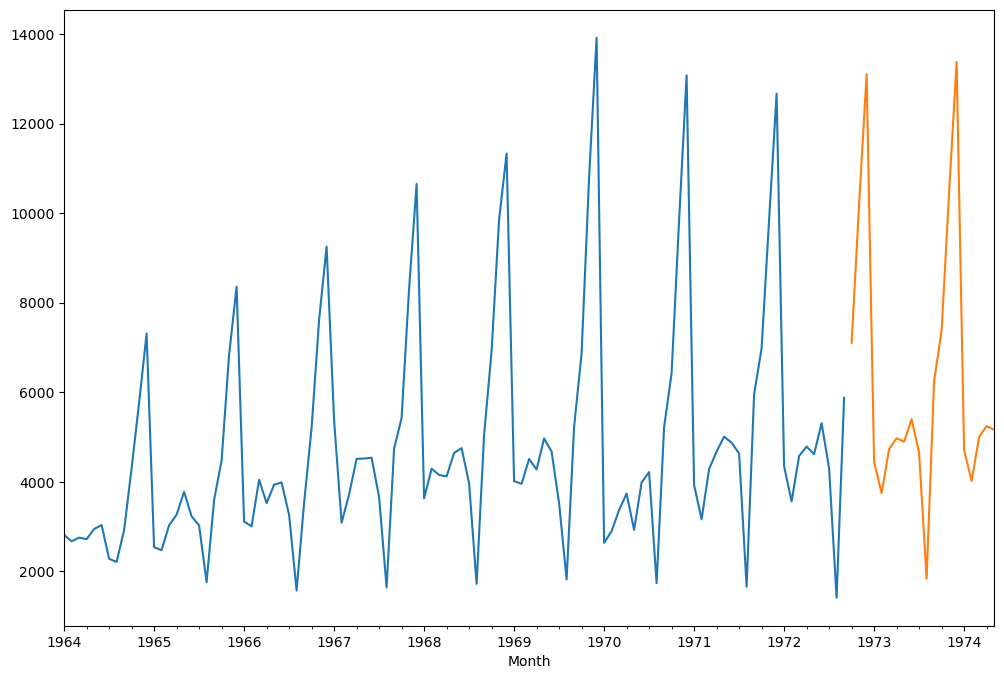

In [161]:
df['sales'].plot(figsize=(12,8))
forecast_predictions.plot()

# FBProphet

In [162]:
from prophet import Prophet

In [163]:
df_pro = df.reset_index()

In [164]:
df_pro

,Month,sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0
...,...,...
100,1972-05-01,4618.0
101,1972-06-01,5312.0
102,1972-07-01,4298.0
103,1972-08-01,1413.0


In [165]:
df

,sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
...,...
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0


##### In Fbprophet it is necessary to covert the column names as 'ds' for date and 'y' for the column to be predicted

In [166]:
df_pro.columns = ['ds', 'y']    
df_pro

,ds,y
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0
...,...,...
100,1972-05-01,4618.0
101,1972-06-01,5312.0
102,1972-07-01,4298.0
103,1972-08-01,1413.0


In [167]:
df_pro['ds'] = pd.to_datetime(df_pro['ds'])

<Axes: xlabel='ds'>

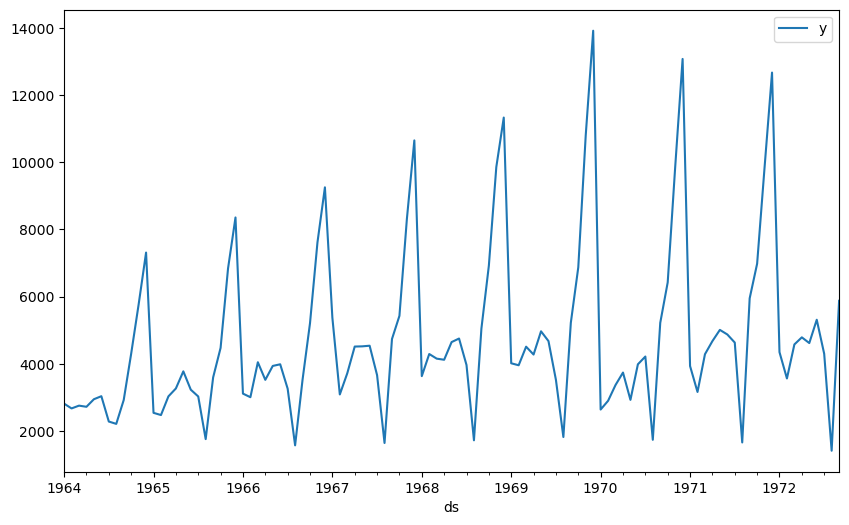

In [168]:
df_pro.plot(x='ds',y='y',figsize=(10,6))

In [169]:
len(df_pro)

105

In [170]:
train_pro = df_pro.iloc[:93]
test_pro = df_pro.iloc[93:]

In [171]:
m = Prophet()                                       
m.fit(train_pro)                                        #fitting the prophet model on train data
future = m.make_future_dataframe(periods=12,freq='MS')  #future will be a new dataframe having the dates of train + periods. Periods is the number of extra points we want to predict over the train data length
forecast = m.predict(future)

05:59:22 - cmdstanpy - INFO - Chain [1] start processing
05:59:22 - cmdstanpy - INFO - Chain [1] done processing


In [172]:
future

,ds
0,1964-01-01
1,1964-02-01
2,1964-03-01
3,1964-04-01
4,1964-05-01
...,...
100,1972-05-01
101,1972-06-01
102,1972-07-01
103,1972-08-01


In [173]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1964-01-01,3568.396384,1470.519045,3447.079267,3568.396384,3568.396384,-1086.148753,-1086.148753,-1086.148753,-1086.148753,-1086.148753,-1086.148753,0.0,0.0,0.0,2482.247631
1,1964-02-01,3598.937526,1108.694718,3011.688790,3598.937526,3598.937526,-1516.057175,-1516.057175,-1516.057175,-1516.057175,-1516.057175,-1516.057175,0.0,0.0,0.0,2082.880351
2,1964-03-01,3627.508272,1956.797476,3901.774720,3627.508272,3627.508272,-737.235743,-737.235743,-737.235743,-737.235743,-737.235743,-737.235743,0.0,0.0,0.0,2890.272529
3,1964-04-01,3658.049414,1653.477268,3551.160907,3658.049414,3658.049414,-1026.198640,-1026.198640,-1026.198640,-1026.198640,-1026.198640,-1026.198640,0.0,0.0,0.0,2631.850773
4,1964-05-01,3687.605358,1996.044797,3994.749404,3687.605358,3687.605358,-697.321524,-697.321524,-697.321524,-697.321524,-697.321524,-697.321524,0.0,0.0,0.0,2990.283834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,1972-05-01,5929.502981,4246.234975,6219.307287,5924.579765,5934.473320,-697.321524,-697.321524,-697.321524,-697.321524,-697.321524,-697.321524,0.0,0.0,0.0,5232.181457
101,1972-06-01,5947.074586,4224.656918,6151.021598,5941.217319,5952.971511,-818.187461,-818.187461,-818.187461,-818.187461,-818.187461,-818.187461,0.0,0.0,0.0,5128.887125
102,1972-07-01,5964.079364,3362.764620,5340.359602,5956.957842,5971.133192,-1582.882438,-1582.882438,-1582.882438,-1582.882438,-1582.882438,-1582.882438,0.0,0.0,0.0,4381.196926
103,1972-08-01,5981.650969,2332.940700,4245.743476,5973.254465,5989.993606,-2677.880776,-2677.880776,-2677.880776,-2677.880776,-2677.880776,-2677.880776,0.0,0.0,0.0,3303.770192


In [174]:
test_pro

,ds,y
93,1971-10-01,6981.0
94,1971-11-01,9851.0
95,1971-12-01,12670.0
96,1972-01-01,4348.0
97,1972-02-01,3564.0
98,1972-03-01,4577.0
99,1972-04-01,4788.0
100,1972-05-01,4618.0
101,1972-06-01,5312.0
102,1972-07-01,4298.0


<Axes: xlabel='ds'>

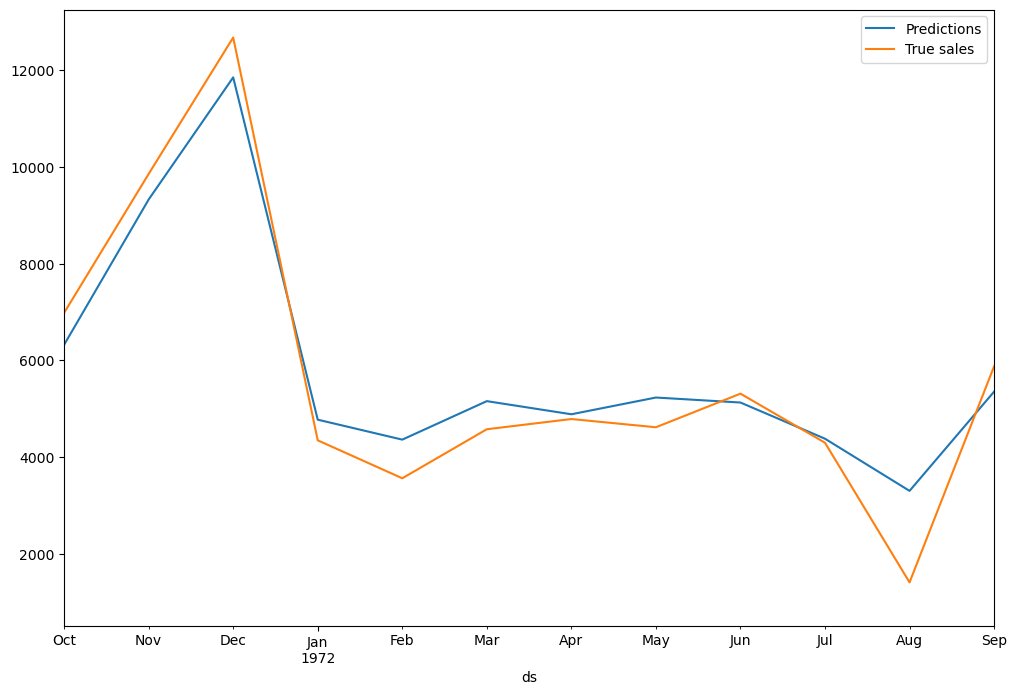

In [175]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))

test_pro.plot(x='ds',y='y',label='True sales',legend=True,ax=ax,xlim=('1971-10-01','1972-09-01'))

### Evaluating the prediction with rmse

In [176]:
from statsmodels.tools.eval_measures import rmse

In [177]:
predictions = forecast.iloc[-12:]['yhat']
predictions

93      6321.829197
94      9322.691660
95     11846.913891
96      4774.768289
97      4362.431471
98      5157.690856
99      4886.299562
100     5232.181457
101     5128.887125
102     4381.196926
103     3303.770192
104     5354.129174
Name: yhat, dtype: float64

In [178]:
test_pro['y']

93      6981.0
94      9851.0
95     12670.0
96      4348.0
97      3564.0
98      4577.0
99      4788.0
100     4618.0
101     5312.0
102     4298.0
103     1413.0
104     5877.0
Name: y, dtype: float64

In [179]:
rmse(predictions,test_pro['y'])

754.0806759525776

### Predicting one year sales

In [180]:
f = Prophet()
f.fit(df_pro)

05:59:24 - cmdstanpy - INFO - Chain [1] start processing
05:59:24 - cmdstanpy - INFO - Chain [1] done processing


In [181]:
future = f.make_future_dataframe(periods=12,freq='MS')
forecast = f.predict(future)

In [182]:
df_pro.tail()

,ds,y
100,1972-05-01,4618.0
101,1972-06-01,5312.0
102,1972-07-01,4298.0
103,1972-08-01,1413.0
104,1972-09-01,5877.0


In [183]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
112,1973-05-01,5906.477205,4285.178273,6179.770336,5899.159023,5912.504986,-718.445566,-718.445566,-718.445566,-718.445566,-718.445566,-718.445566,0.0,0.0,0.0,5188.031639
113,1973-06-01,5919.962881,4354.558581,6257.616589,5911.321428,5927.251885,-618.808410,-618.808410,-618.808410,-618.808410,-618.808410,-618.808410,0.0,0.0,0.0,5301.154470
114,1973-07-01,5933.013535,3708.158085,5544.677126,5922.965897,5942.146750,-1299.432717,-1299.432717,-1299.432717,-1299.432717,-1299.432717,-1299.432717,0.0,0.0,0.0,4633.580818
115,1973-08-01,5946.499211,1887.208393,3749.628900,5934.762203,5956.834648,-3143.505401,-3143.505401,-3143.505401,-3143.505401,-3143.505401,-3143.505401,0.0,0.0,0.0,2802.993810
116,1973-09-01,5959.984887,4752.061216,6613.320027,5945.924870,5971.675539,-283.218673,-283.218673,-283.218673,-283.218673,-283.218673,-283.218673,0.0,0.0,0.0,5676.766213


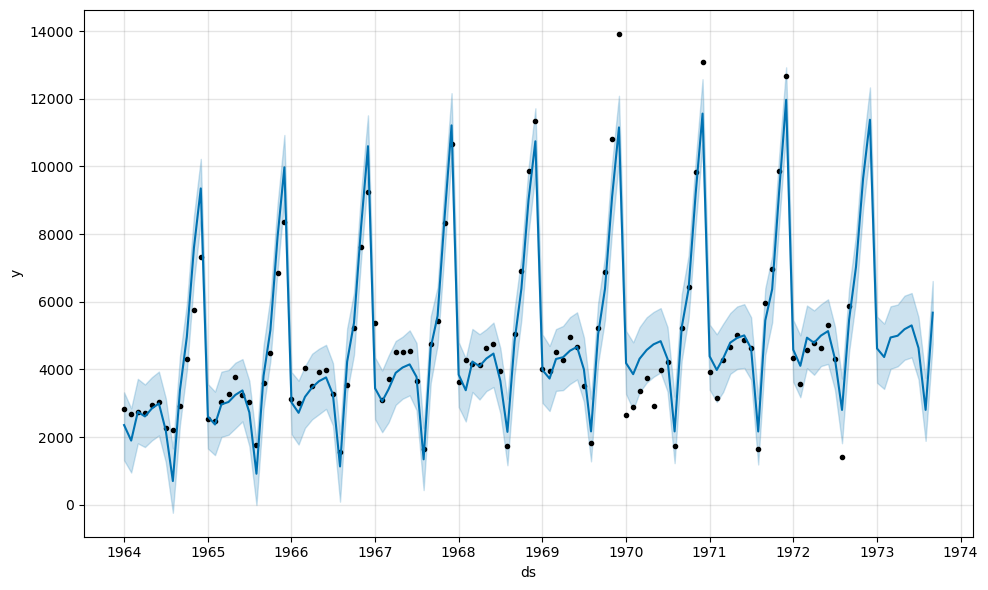

In [184]:
f.plot(forecast);

# SARIMA

In [185]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [186]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders


In [187]:
df

,sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
...,...
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0


<Axes: xlabel='Month'>

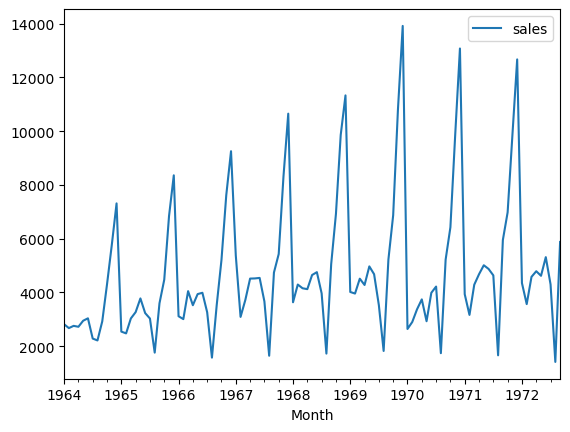

In [188]:
df.plot()

### Run an ETS decomposition

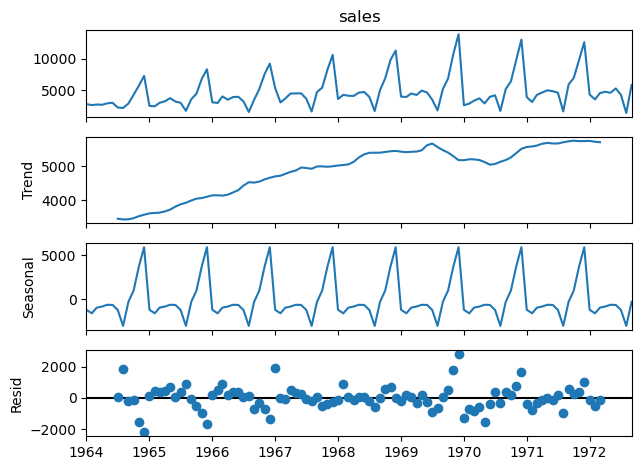

In [189]:
result = seasonal_decompose(df['sales'], model='add')
result.plot();

An annual seasonality and a positive trend is observed

In [190]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df['sales'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  105
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 12)   Log Likelihood                -745.083
Date:                             Tue, 22 Aug 2023   AIC                           1498.167
Time:                                     05:59:58   BIC                           1508.297
Sample:                                 01-01-1964   HQIC                          1502.257
                                      - 09-01-1972                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    362.8400    100.620      3.606      0.000     165.628     560.052
ma.L1          0.2191      0.074      2.970      0.003       0.075       0.364
ar.S.L12      -0.1784      0.082     -2.186      0.029      -0.338      -0.018
sigma2      5.135e+05   5.75e+04      8.924      0.000    4.01e+05    6.26e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                 8.20
Prob(Q):                              0.55   Prob(JB):                         0.02
Heteroskedasticity (H):               1.27   Skew:                            -0.15
Prob(H) (two-sided):                  0.50   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Train test split

In [191]:
train_data = df.iloc[:93] # Goes up to but not including 93
test_data = df.iloc[93:]
test_data.shape

(12, 1)

In [192]:
test_data

,sales
Month,
1971-10-01,6981.0
1971-11-01,9851.0
1971-12-01,12670.0
1972-01-01,4348.0
1972-02-01,3564.0
1972-03-01,4577.0
1972-04-01,4788.0
1972-05-01,4618.0
1972-06-01,5312.0


### Fit a SARIMA(0,0,1)(1,1,0,12) Model

In [193]:
model = SARIMAX(train_data['sales'],order=(0,0,1),seasonal_order=(1,1,0,12))
results = model.fit()
results.summary()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.08739D+00    |proj g|=  6.91294D-02

At iterate    5    f=  7.08528D+00    |proj g|=  1.42428D-04

At iterate   10    f=  7.08523D+00    |proj g|=  8.10878D-03

At iterate   15    f=  7.08416D+00    |proj g|=  1.99454D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     24      1     0     0   9.475D-07   7.084D+00
  F =   7.0838904834447805     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               sales   No. Observations:                   93
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 12)   Log Likelihood                -658.802
Date:                             Tue, 22 Aug 2023   AIC                           1323.604
Time:                                     05:59:58   BIC                           1330.787
Sample:                                 01-01-1964   HQIC                          1326.486
                                      - 09-01-1971                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2631      0.091      2.887      0.004       0.084       0.442
ar.S.L12      -0.0654      0.088     -0.743      0.458      -0.238       0.107
sigma2      6.639e+05   8.97e+04      7.401      0.000    4.88e+05     8.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 7.33
Prob(Q):                              0.76   Prob(JB):                         0.03
Heteroskedasticity (H):               1.75   Skew:                            -0.29
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [194]:
# Obtain predicted values
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,0,1)(1,1,0,12) Predictions')

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [195]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test_data['sales'][i]}")

predicted=6657.797041, expected=6981.0
predicted=9904.852739, expected=9851.0
predicted=13130.93892, expected=12670.0
predicted=3849.3025  , expected=4348.0
predicted=3144.798886, expected=3564.0
predicted=4226.090417, expected=4577.0
predicted=4614.782348, expected=4788.0
predicted=4873.764562, expected=4618.0
predicted=4815.921715, expected=5312.0
predicted=4605.792155, expected=4298.0
predicted=1664.166874, expected=1413.0
predicted=5903.255464, expected=5877.0


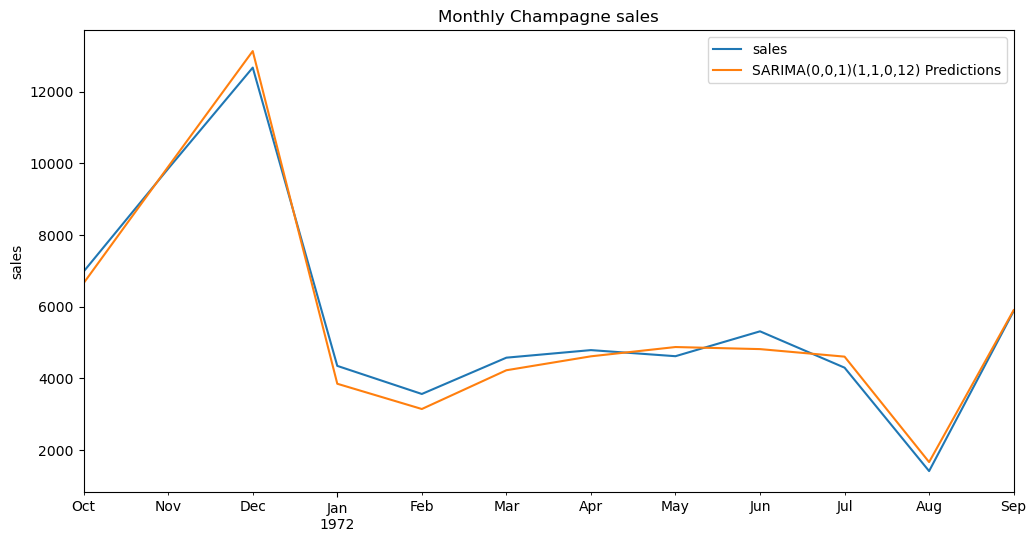

In [196]:
# Plot predictions against known values
title = 'Monthly Champagne sales'
ylabel='sales'
xlabel=''

ax = test_data['sales'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Evaluate the model

In [197]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test_data['sales'], predictions)
print(f'SARIMA(0,0,1)(1,1,0,12) RMSE Error: {error:11.10}')

SARIMA(0,0,1)(1,1,0,12) RMSE Error: 337.5666542


### Retrain the model on the full data, and forecast the future

In [198]:
model = SARIMAX(df['sales'],order=(0,0,1),seasonal_order=(1,1,0,12))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(0,0,1)(1,1,0,12) Forecast')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.15499D+00    |proj g|=  4.19210D-02


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  7.15428D+00    |proj g|=  1.90281D-04

At iterate   10    f=  7.15424D+00    |proj g|=  7.07519D-03

At iterate   15    f=  7.15324D+00    |proj g|=  1.11914D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     24      1     0     0   6.165D-06   7.153D+00
  F =   7.1531735511512462     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


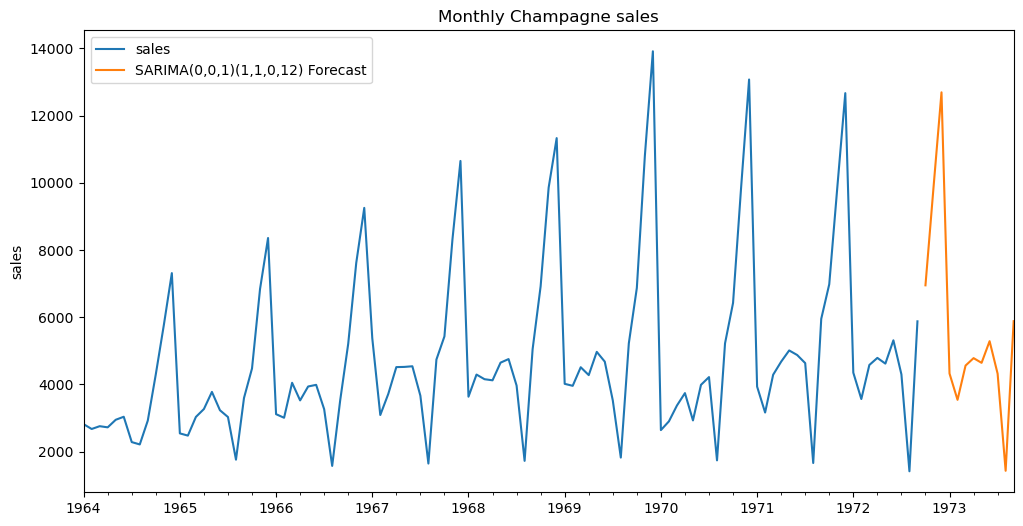

In [199]:
# Plot predictions against known values
title = 'Monthly Champagne sales'
ylabel='sales'
xlabel=''

ax = df['sales'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## LSTM

In [106]:
train_lstm = df.iloc[:93]
test_lstm = df.iloc[93:]
test_lstm.shape

(12, 1)

scaling the data

In [107]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [108]:
scaler.fit(train_lstm)
scaled_train = scaler.transform(train_lstm)
scaled_test = scaler.transform(test_lstm)

Preparing data for feeding into LSTM

In [109]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [112]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

Applying LSTM

In [113]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [232]:
# Define model
model = Sequential()
model.add(LSTM(130, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [233]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 130)               68640     
                                                                 
 dense_9 (Dense)             (None, 1)                 131       
                                                                 
Total params: 68,771
Trainable params: 68,771
Non-trainable params: 0
_________________________________________________________________


In [234]:
# fit model
model.fit(generator,epochs=80)

Epoch 1/80
81/81 [==============================] - 2s 6ms/step - loss: 0.0485
Epoch 2/80
81/81 [==============================] - 1s 6ms/step - loss: 0.0460
Epoch 3/80
81/81 [==============================] - 1s 6ms/step - loss: 0.0400
Epoch 4/80
81/81 [==============================] - 1s 7ms/step - loss: 0.0345
Epoch 5/80
81/81 [==============================] - 1s 7ms/step - loss: 0.0345
Epoch 6/80
81/81 [==============================] - 1s 7ms/step - loss: 0.0336
Epoch 7/80
81/81 [==============================] - 1s 6ms/step - loss: 0.0221
Epoch 8/80
81/81 [==============================] - 1s 6ms/step - loss: 0.0199
Epoch 9/80
81/81 [==============================] - 1s 7ms/step - loss: 0.0270
Epoch 10/80
81/81 [==============================] - 1s 6ms/step - loss: 0.0136
Epoch 11/80
81/81 [==============================] - 1s 6ms/step - loss: 0.0110
Epoch 12/80
81/81 [==============================] - 1s 6ms/step - loss: 0.0120
Epoch 13/80
81/81 [==============================

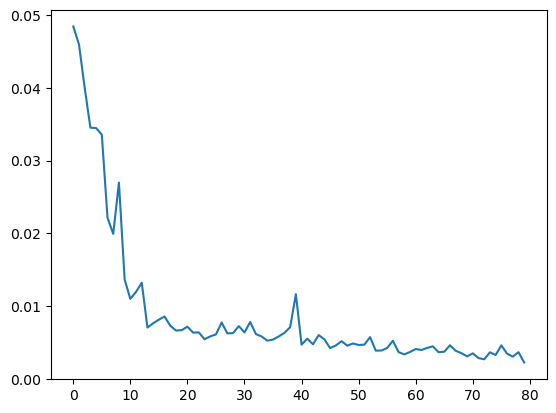

In [235]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

### Evaluate on test data

In [236]:
first_eval_batch = scaled_train[-12:]

In [237]:
first_eval_batch

array([[0.39301628],
       [0.66993438],
       [0.93194523],
       [0.19128251],
       [0.12873694],
       [0.2198007 ],
       [0.25139755],
       [0.27845743],
       [0.26743903],
       [0.2479138 ],
       [0.00696751],
       [0.35469497]])

In [238]:
first_eval_batch = first_eval_batch.reshape((1, 12, n_features))

## Generating predictions into the same time stamps as the test set

In [239]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_lstm)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 21ms/step


## Inverse Transformations and Compare

In [240]:
true_predictions = scaler.inverse_transform(test_predictions)

In [241]:
true_predictions

array([[ 7119.96622238],
       [10028.02843279],
       [13221.05990821],
       [ 3913.5037154 ],
       [ 3374.45488116],
       [ 3840.33822224],
       [ 4185.77898812],
       [ 4526.50613078],
       [ 4722.13565415],
       [ 4860.27499676],
       [ 1959.62109295],
       [ 5980.8083159 ]])

In [242]:
test_lstm['Predictions'] = true_predictions

/tmp/ipykernel_32/1794037213.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_lstm['Predictions'] = true_predictions


In [243]:
test_lstm

,sales,Predictions
Month,,
1971-10-01,6981.0,7119.966222
1971-11-01,9851.0,10028.028433
1971-12-01,12670.0,13221.059908
1972-01-01,4348.0,3913.503715
1972-02-01,3564.0,3374.454881
1972-03-01,4577.0,3840.338222
1972-04-01,4788.0,4185.778988
1972-05-01,4618.0,4526.506131
1972-06-01,5312.0,4722.135654


<Axes: xlabel='Month'>

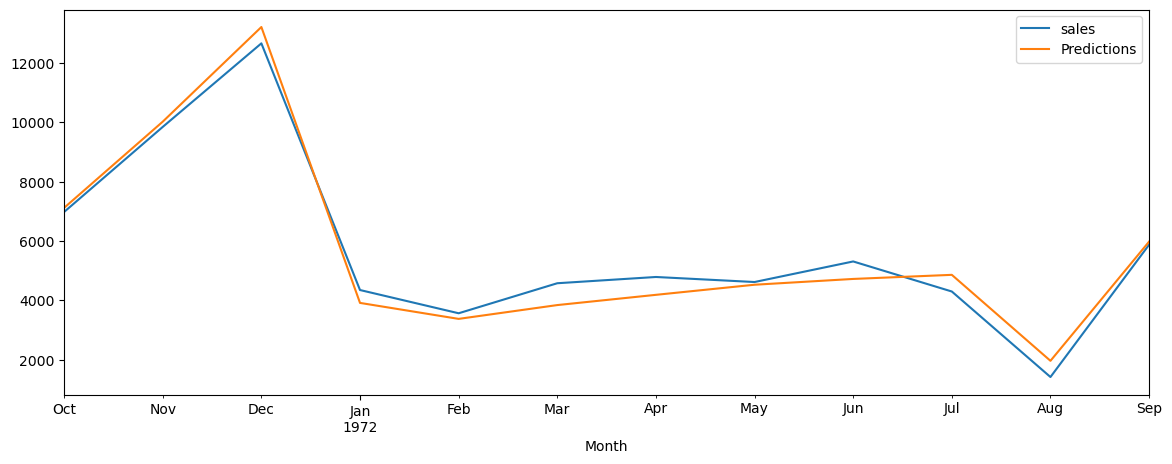

In [244]:
test_lstm.plot(figsize=(14,5))

In [245]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test_lstm['sales'],test_lstm['Predictions']))
print(rmse)

453.35856183665294


Predicting for future 12 months

In [246]:
data = df.iloc[:]
data.shape

(105, 1)

In [247]:
scaler.fit(data)
scaled_data = scaler.transform(data)

In [248]:
# define generator
n_input = 12
n_features = 1
generator_f = TimeseriesGenerator(scaled_data, scaled_data, length=n_input, batch_size=1)

In [249]:
future_predictions = []

first_eval_batch = scaled_data[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(12):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    future_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 23ms/step


In [250]:
future_predictions = scaler.inverse_transform(future_predictions)
future_predictions

array([[ 7530.92821419],
       [10169.979662  ],
       [13115.72812849],
       [ 4146.07612106],
       [ 3503.75347874],
       [ 4015.43460664],
       [ 4277.64992681],
       [ 4446.3231146 ],
       [ 4925.21456531],
       [ 4780.54955602],
       [ 1879.41208664],
       [ 5999.4686746 ]])

In [251]:
df.tail()

,sales
Month,
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0
1972-08-01,1413.0
1972-09-01,5877.0


In [252]:
date_idx = pd.date_range('1972-09-01', periods=12,freq='M')
date_idx 

DatetimeIndex(['1972-09-30', '1972-10-31', '1972-11-30', '1972-12-31',
               '1973-01-31', '1973-02-28', '1973-03-31', '1973-04-30',
               '1973-05-31', '1973-06-30', '1973-07-31', '1973-08-31'],
              dtype='datetime64[ns]', freq='M')

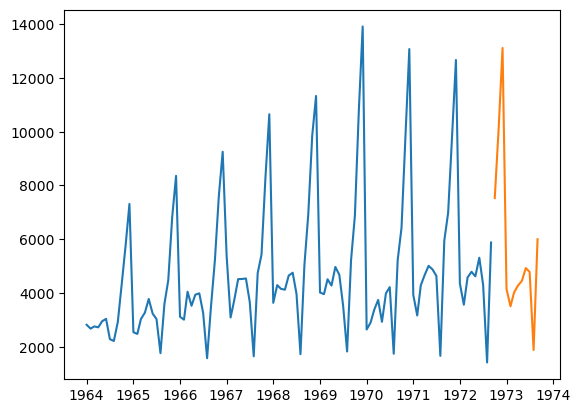

In [253]:
plt.plot(df['sales'])
plt.plot(date_idx,future_predictions)